# Лабораторная работа 4

## Выполнила Кривоконева Екатерина, группа 6233-010402D

### Задание

В данной лабораторной работе будет практиковаться материал из лекций по TensorFlow на примере решения задачи классификации изображений из датасета Fashion MNIST. Fashion MNIST - набор черно-белых изображений размера 28х28, что поделены на 10 классов. Будет построена с нуля и обучена модель логистической регрессии используя как низкоуровневый API. Опционально решение той же задачи нейронной сетью, построенной и обученной с использованием Keras.

### 0 Базовые операции. 
   - 0.1 Сгенерируйте три непересекающихся гауссовых облака, используя `tf.random`. Визуализируйте их разными цветами, используя matplotlib. 
   - 0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm


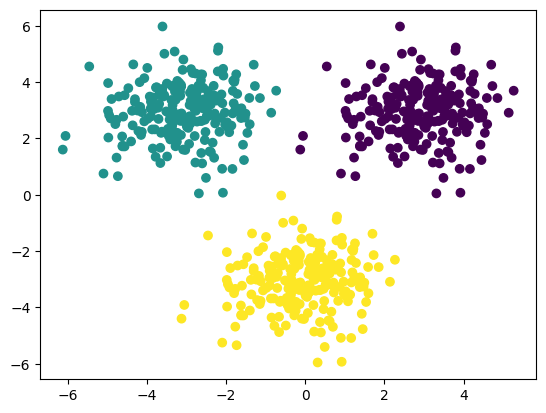

In [2]:
N = 223
noise = tf.random.normal((N, 2), 0, 1)

cloud1 = noise + np.array([3, 3])
cloud2 = noise + np.array([-3, 3])
cloud3 = noise + np.array([0, -3])

data = np.vstack([cloud1, cloud2, cloud3])

annotation1 = [0] * N
annotation2 = [1] * N
annotation3 = [2] * N

annotations = annotation1 + annotation2 + annotation3

plt.scatter(data[:,0], data[:,1], c=annotations)

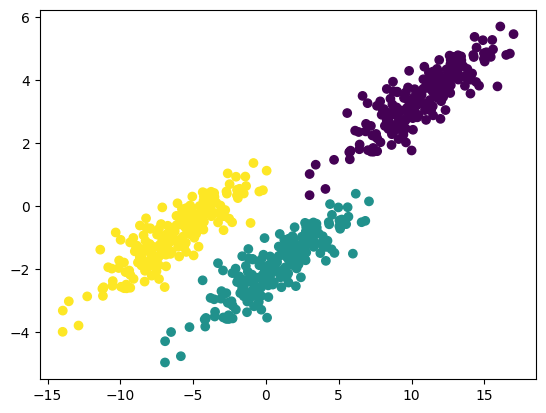

In [3]:
matr = tf.random.uniform((2, 2), 0, 2)

cloud11 = tf.matmul(cloud1, matr)
cloud21 = tf.matmul(cloud2, matr)
cloud31 = tf.matmul(cloud3, matr)

data1 = np.vstack([cloud11, cloud21, cloud31])

plt.scatter(data1[:,0], data1[:,1], c=annotations)

### 1 Загрузите датасет Fashion MNIST, используя метод из [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). Визуализируйте несколько изображений, используя библиотеку matplotlib.

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Тренировочный набор: X={X_train.shape}, y={y_train.shape}")
print(f"Тестовый набор данных: X={X_test.shape}, y={y_test.shape}")

Тренировочный набор: X=(60000, 28, 28), y=(60000,)
Тестовый набор данных: X=(10000, 28, 28), y=(10000,)


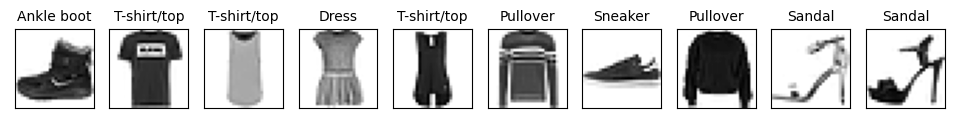

In [5]:
def plot_first_images(img, labels, idx, num):
    pred = []
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    for i in range(0, num):
        ax = plt.subplot(5, 10, 1 + i)
        ax.imshow(img[idx], cmap = 'binary')
        title = class_names[labels[i]]
        ax.set_title(title, fontsize = 10)
        ax.set_xticks([]); ax.set_yticks([])
        idx += 1
    plt.show()
plot_first_images (X_train, y_train, 0, 10)

### 2 Нормализуйте данные либо средним и СКО, либо приведя значения пикселей в интервал [-1, 1].

In [6]:
x_train = X_train.reshape(60000, -1)
x_test = X_test.reshape(10000, -1)

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

mean, std = x_train.mean(axis=0), x_train.std(axis=0)
x_train = (x_train - mean) / (std + 1e-3)
x_test = (x_test - mean) / (std + 1e-3)

### 3 Создайте обучающий и тестовый TensorFlow Dataset из нормализованного набора данных. К обучающему датасету добавьте перемешивание (`.shuffle`). К обоим датасетам добавьте генерацию батчей размера 128 (`.batch(128)`).

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.shuffle(buffer_size=len(x_train), reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)

### 4 Напишите класс слоя `Flatten`, что трансформирует изображения из матричного в векторный вид: [28, 28] -> [28 * 28]. Класс слоя должен наследоваться от `tf.Module`. Для трансформации тензоров изображений использовать `tf.reshape`.

In [9]:
class Flatten(tf.Module):

    def __init__(self, name=None):
        super().__init__(name=name)

    def __call__(self, data):
        if len(data.shape) == 1:
            new_shape = data.shape
        elif len(data.shape) == 2:
            new_shape = (1, np.prod(data.shape))
        else:
            new_shape = (data.shape[0], np.prod(data.shape[1:]))
        return tf.reshape(data, shape=new_shape)

### 5 Напишите класс линейного слоя `Linear`, что умножает входной вектор на матрицу весов. Класс слоя должен наследоваться от `tf.Module`. Матрицу весов хранить в `tf.Variable`. Параметры конструктора: `in_d` - размерность входного вектора, `out_d` - размерность выходного вектора. В качестве начальной инициализации весов использовать гауссово распределение с СКО=0.01.

In [10]:
class Linear(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        super().__init__(name=name)
        w = tf.random.normal(shape=[in_d, out_d], stddev=0.01, dtype='float32')
        self.w = tf.Variable(w, name='linear')
        self.b = tf.Variable(tf.zeros(out_d, dtype='float32'), name='bias')

    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b

### 6 Напишите класс модели логистической регрессии `LogisticRegression`, что компонует в себе слои `Linear` и `Flatten`. Класс модели должен наследоваться от `tf.Module`. В качестве функции активации используйте `tf.nn.softmax`.
Создайте объект модели и попробуйте с помощью неё классифицировать одно изображение (не забудьте о размерности батча! Она будет равна 1).

In [11]:
class LogisticRegression(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        super().__init__(name=name)
        linear_name = None
        if name is not None:
            linear_name = name + '_linear'
        self.linear = Linear(in_d, out_d, name=linear_name)

    def __call__(self, x):
        x = self.linear(x)
        return tf.nn.softmax(x)

In [12]:
model = logistic_regression = LogisticRegression(28*28,10)
preds = logistic_regression(x_train[0:1])

tf.argmax(preds, axis=1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([4], dtype=int64)>

### 7 Напишите функцию оценки точности модели `evaluate`. Список её аргументов: тестовый tf.Dataset, модель. Данная функция будет отличаться оной из лекций тем, что внутри неё не будет ручной выборки батчей из датасета, поскольку tf.Dataset уже делает это за нас.

In [13]:
def accuracy(y_true, y_pred):
    eq = tf.cast(y_true == y_pred, 'float32')
    return tf.reduce_mean(eq)


def evaluate(model, data: tf.data.Dataset) -> np.ndarray:
    y_preds = []
    y_true = []

    for x_batch, y_batch in data:
        preds = model(x_batch)
        preds = tf.argmax(preds, axis=-1)
        y_preds.append(preds)
        y_true.extend(y_batch)

    y_preds = tf.concat(y_preds, axis=0)
    return accuracy(y_true, y_preds).numpy()

### 8 Напишите функцию обучающего шага `train_step`. Данная функция будет немного отличаться от показанной в лекции тем, что ей на вход также дается функция ошибки. Полный список аргументов: модель, тупл данных (батч картинок, батч меток), оптимизатор, функция ошибки. Функция `train_step` должна возвращать вычисленное значение функции ошибки.

В данной лабораторной функция ошибки не будет писаться заново, будет использоваться готовая кросс-энтропия из Keras.

In [14]:
def train_step(model, data, optim, criterion):
    with tf.GradientTape() as tape:
        x, y = data
        preds = model(x)
        loss = criterion(y, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(grads, model.trainable_variables))
    return loss

### 9 Оцените точность модели.

In [15]:
evaluate(logistic_regression, train_dataset)

0.10715

### 10 Подготовьте гиперпараметры обучения: оптимизатор, функция ошибки ([tf.keras.losses.SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)), количество эпох.

In [16]:
epochs = 5
print_period = 100

optim = tf.optimizers.Adam(learning_rate=0.005)
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()

### 11 Напишите обучающий цикл. Цикл состоит из внешнего цикла, что отсчитывает эпохи, и вложенного, что итерируется по обучающему датасету.
Во вложенном цикле должна вызываться функция `train_step`. Каждую эпоху модель должна тестироваться функцией `evaluate`. Должны выводиться номер эпохи, значение ошибки и точности. Сохраняйте значения ошибки и точности в списки. Обучите модель. По ходу обучения подбирайте более оптимальные гиперпараметры обучения (learning_rate, другой оптимизатор).

In [17]:
loss_data = []
acc_data = []
for epoch in range(epochs):
    cnt = 0
    for x,y in tqdm(train_dataset):

        loss = train_step(model, (x,y), optim, cross_entropy)

        if cnt % print_period == 0:
            print('Epoch:', epoch, 'Iteration:', cnt, 'Loss:', loss.numpy())
        loss_data.append(loss.numpy())
        cnt += 1

    acc = evaluate(model, test_dataset)
    print('Epoch:', epoch, 'Accuracy:', acc)
    acc_data.append(acc)

  2%|▏         | 11/469 [00:00<00:10, 45.34it/s]

Epoch: 0 Iteration: 0 Loss: 2.2872252


 25%|██▌       | 119/469 [00:01<00:03, 98.81it/s]

Epoch: 0 Iteration: 100 Loss: 0.54199374


 46%|████▋     | 218/469 [00:02<00:02, 106.03it/s]

Epoch: 0 Iteration: 200 Loss: 0.5488018


 68%|██████▊   | 317/469 [00:03<00:01, 107.17it/s]

Epoch: 0 Iteration: 300 Loss: 0.92325294


 89%|████████▊ | 416/469 [00:04<00:00, 106.54it/s]

Epoch: 0 Iteration: 400 Loss: 0.46536595


100%|██████████| 469/469 [00:04<00:00, 100.13it/s]


Epoch: 0 Accuracy: 0.8267


  1%|▏         | 6/469 [00:00<00:08, 53.57it/s]

Epoch: 1 Iteration: 0 Loss: 0.46439177


 24%|██▍       | 112/469 [00:01<00:03, 100.66it/s]

Epoch: 1 Iteration: 100 Loss: 0.70323324


 45%|████▍     | 211/469 [00:02<00:02, 94.11it/s] 

Epoch: 1 Iteration: 200 Loss: 0.424313


 66%|██████▋   | 311/469 [00:03<00:01, 90.00it/s]

Epoch: 1 Iteration: 300 Loss: 0.36700284


 89%|████████▊ | 416/469 [00:04<00:00, 97.38it/s] 

Epoch: 1 Iteration: 400 Loss: 0.33718598


100%|██████████| 469/469 [00:04<00:00, 93.87it/s] 


Epoch: 1 Accuracy: 0.8217


  1%|▏         | 7/469 [00:00<00:06, 66.04it/s]

Epoch: 2 Iteration: 0 Loss: 0.33229476


 25%|██▍       | 116/469 [00:01<00:03, 89.90it/s]

Epoch: 2 Iteration: 100 Loss: 0.45829853


 46%|████▋     | 218/469 [00:02<00:02, 98.49it/s]

Epoch: 2 Iteration: 200 Loss: 0.5198469


 68%|██████▊   | 317/469 [00:03<00:01, 99.85it/s] 

Epoch: 2 Iteration: 300 Loss: 0.50273234


 88%|████████▊ | 413/469 [00:04<00:00, 85.75it/s]

Epoch: 2 Iteration: 400 Loss: 0.47652847


100%|██████████| 469/469 [00:05<00:00, 91.92it/s]


Epoch: 2 Accuracy: 0.8195


  4%|▍         | 18/469 [00:00<00:05, 89.46it/s]

Epoch: 3 Iteration: 0 Loss: 0.5504582


 25%|██▌       | 118/469 [00:01<00:03, 106.86it/s]

Epoch: 3 Iteration: 100 Loss: 0.38529077


 46%|████▋     | 217/469 [00:02<00:02, 105.69it/s]

Epoch: 3 Iteration: 200 Loss: 0.42262307


 67%|██████▋   | 315/469 [00:03<00:01, 91.83it/s] 

Epoch: 3 Iteration: 300 Loss: 0.50123197


 88%|████████▊ | 413/469 [00:04<00:00, 103.19it/s]

Epoch: 3 Iteration: 400 Loss: 0.47572315


100%|██████████| 469/469 [00:04<00:00, 100.68it/s]


Epoch: 3 Accuracy: 0.8273


  1%|▏         | 7/469 [00:00<00:07, 65.88it/s]

Epoch: 4 Iteration: 0 Loss: 0.55686545


 25%|██▍       | 117/469 [00:01<00:03, 105.61it/s]

Epoch: 4 Iteration: 100 Loss: 0.32308328


 46%|████▌     | 216/469 [00:02<00:02, 104.71it/s]

Epoch: 4 Iteration: 200 Loss: 0.30208355


 67%|██████▋   | 315/469 [00:03<00:01, 101.28it/s]

Epoch: 4 Iteration: 300 Loss: 0.57977915


 88%|████████▊ | 414/469 [00:04<00:00, 102.91it/s]

Epoch: 4 Iteration: 400 Loss: 0.43806309


100%|██████████| 469/469 [00:04<00:00, 101.32it/s]


Epoch: 4 Accuracy: 0.8325


### 12 Выведите графики точности и ошибки, используя matplotlib.

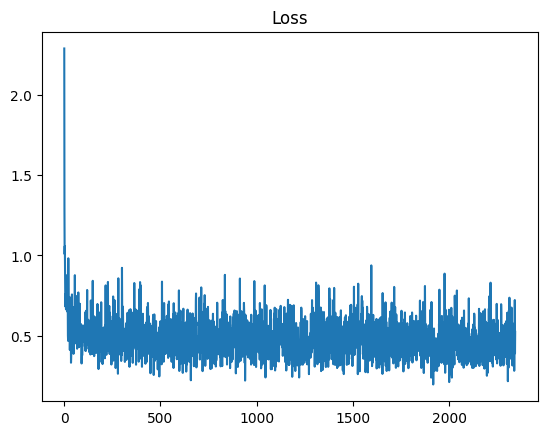

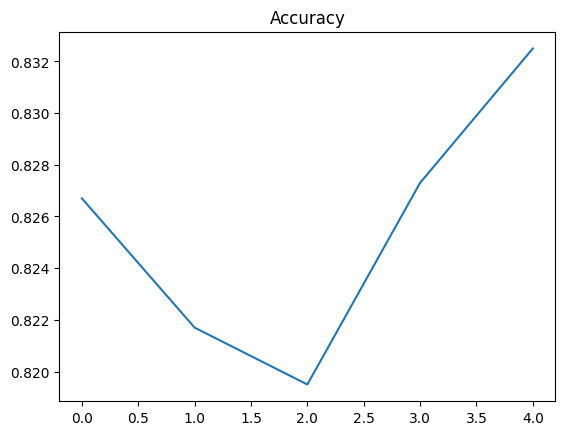

In [18]:
plt.plot(np.arange(0, len(loss_data), 1), loss_data)
plt.title("Loss")
plt.show()

plt.plot(np.arange(0, len(acc_data), 1), acc_data)
plt.title("Accuracy")
plt.show()